In [1]:
using SparseArrays, LinearAlgebra, ArnoldiMethod
using ArnoldiMethod: SR
using LsqFit
using LaTeXStrings
using Plots
using Statistics
using ProgressMeter

id = [1 0; 0 1] |> sparse
sx = [0 1; 1 0] |> sparse
sz = [1 0; 0 -1] |> sparse;

In [2]:
function build_HA(ns, Szi, A=50)
    N = 4 + 3*(ns - 1)
    
    Heff = zeros(N+1, N+1)
    
    IdN = sparse(1.0I, 2^N, 2^N)

    Hs = A/4 * (2*IdN + 2*Szi[1]*Szi[ns+1])
    Ht = A/4 * (2*IdN + 2*Szi[N]*Szi[2*ns+1])
    
    Heff[2, ns+2] += 2
    Heff[2*ns+2, N+1] += 2
    
    Hij = spzeros(Int, 2^N, 2^N)
    
    # source and target horizontal edges
    Hij += IdN - Szi[1]*(Szi[2] + Szi[ns+2]) - 2*Szi[1]
    Hij += IdN - Szi[N]*(Szi[2*ns] + Szi[N-1]) - 2*Szi[N]
    
    Heff[2, 3] += -1
    Heff[2, ns+3] += -1
    Heff[1, 2] += -2
    
    Heff[2*ns+1, N+1] += -1
    Heff[N, N+1] += -1
    Heff[1, N+1] += -2

    # horizontal corner edges
    Hij += 2*IdN + Szi[ns]*(Szi[2*ns] - Szi[ns-1] - Szi[2*ns+1]) + 2*Szi[ns]
    Hij += 2*IdN + Szi[2*ns+2]*(Szi[ns+2] - Szi[2*ns+3] - Szi[ns+1]) + 2*Szi[2*ns+2]
    
    Heff[ns+1, 2*ns+1] += 1
    Heff[ns, ns+1] += -1
    Heff[ns+1, 2*ns+2] += -1
    Heff[1, ns+1] += 2
    
    Heff[ns+3, 2*ns+3] += 1
    Heff[2*ns+3, 2*ns+4] += -1
    Heff[ns+2, 2*ns+3] += -1
    Heff[1, 2*ns+3] += 2
    
    # vertical corner edges
    Hij += IdN - Szi[ns+1]*Szi[2*ns+2]
    Hij += IdN - Szi[2*ns+1]*Szi[ns]
    
    Heff[ns+2, 2*ns+3] += -1
    Heff[ns+1, 2*ns+2] += -1
    
    # lower horizontal internal edges
    for i in 2:ns-1
        Hij += 2*IdN + Szi[i]*(Szi[i+ns] - Szi[i-1] - Szi[i+ns+1] - Szi[i+1])
        
        Heff[i+1, i+1+ns] += 1
        Heff[i, i+1] += -1
        Heff[i+1, i+ns+2] += -1
        Heff[i+1, i+2] += -1
    end
    # vertical internal edges
    for i in ns+2:2*ns
        Hij += 4*IdN + Szi[i]*(Szi[i-ns] + Szi[i+ns] - Szi[i-ns-1] - Szi[i+ns+1]) + 4*Szi[i]
        
        Heff[i+1-ns, i+1] += 1
        Heff[i+1, i+1+ns] += 1
        Heff[i-ns, i+1] += -1
        Heff[i+1, i+ns+2] += -1
        Heff[1, i+1] += 4
    end
    # higher horizontal internal edges
    for i in 2*ns+3:N-1
        Hij += 2*IdN + Szi[i]*(Szi[i-ns] - Szi[i-1] - Szi[i-ns-1] - Szi[i+1])
        
        Heff[i+1-ns, i+1] += 1
        Heff[i, i+1] += -1
        Heff[i-ns, i+1] += -1
        Heff[i+1, i+2] += -1
    end
    
    Heff = A/4 * Heff
    Heff = Heff .+ transpose(Heff)
    
    Hij = A/4 * Hij
    HA = Hs + Ht + Hij

    HA, Heff
end


function build_HB(ns, Szi, W, B=1)
    N = 4 + 3*(ns - 1)
    
    IdN = sparse(1.0I, 2^N, 2^N)

    HB = B / 2 * sum(W) * IdN
    for i in 1:N
        HB += B / 2 * W[i] * Szi[i]
    end

    HB
end


function build_Hx(ns)
    N = 4 + 3*(ns - 1)
    
    # vector of operators: [sx, id, ...]
    Sx_list = fill(id, N)
    Sx_list[1] = sx

    HX = spzeros(Int, 2^N, 2^N)
    for i in 1:N
        HX -= foldl(kron, Sx_list)
        Sx_list = circshift(Sx_list, 1)
    end
    HX
end;

In [3]:
function eigs(x; nev=2, v1=nothing)
    decomp, history = partialschur(x, nev=nev, which=SR(), v1=nothing)
    e, v = partialeigen(decomp)
    e, v
end


function compute_dH(v1, v2, Szi)
    
    N = trunc(Int, log2(size(v1, 1)))
    
    v1 = round.(v1)
    v2 = round.(v2)
    
    v1z = zeros(N)
    v2z = zeros(N)
    
    for i in 1:N
        v1z[i] = v1' * Szi[i] * v1
        v2z[i] = v2' * Szi[i] * v2
    end

    sum(abs.(v2z .- v1z)) / 2
end;

In [4]:
ns = 1
N = 4

B = 1
A = N*B

IdN = sparse(1.0I, 2^N, 2^N)
    
# vector of operators: [sz, id, id, ...]
Sz_list = fill(id, N)
Sz_list[1] = sz

Szi = fill(IdN, N)
for i in 1:N
    Szi[i] = foldl(kron, Sz_list)
    # cyclic shift the operators
    Sz_list = circshift(Sz_list, 1)
end

Hs = A/4 * (2*IdN + 2*Szi[1]*Szi[2])
Ht = A/4 * (2*IdN + 2*Szi[3]*Szi[4])

Hij = A/4 * (2*IdN - 2*Szi[1]*Szi[3])
Hij += A/4 * (2*IdN - 2*Szi[2]*Szi[4])

HA1 = Hs + Ht + Hij

Heff1 = zeros(N+1, N+1)
Heff1[2, 3] = A/2
Heff1[4, 5] = A/2
Heff1[2, 4] = -A/2
Heff1[3, 5] = -A/2

Heff1 = Heff1 + transpose(Heff1);

In [5]:
using PyCall

py"""
from itertools import islice

import networkx as nx

def two_sp(ns, W):
    G = nx.grid_2d_graph(2, ns+1)
    G = nx.DiGraph(G)
    for edge in G.copy().edges():
        if edge != tuple(sorted(edge)):
            G.remove_edge(*edge)

    source = (0, 0)
    target = (1, ns)

    edges = []
    for i in range(ns):
        edges.append(((0, i), (0, i+1)))
    for i in range(ns+1):
        edges.append(((0, i), (1, i)))
    for i in range(ns):
        edges.append(((1, i), (1, i+1)))
    
    for i, e in enumerate(edges):
        G[e[0]][e[1]]['weight'] = W[i]

    p0, p1 = list(islice(nx.shortest_simple_paths(G, source, target, weight="weight"), 2))
    
    return p0, p1, edges
"""

In [6]:
ns = 3

N = 4 + 3*(ns - 1)
A = N

IdN = sparse(1.0I, 2^N, 2^N)

# vector of operators: [sz, id, id, ...]
Sz_list = fill(id, N)
Sz_list[1] = sz

Szi = fill(IdN, N)
for i in 1:N
    Szi[i] = foldl(kron, Sz_list)
    # cyclic shift the operators
    Sz_list = circshift(Sz_list, 1)
end

if ns != 1
    HA, Heff = build_HA(ns, Szi, A)
else
    HA = copy(HA1)
end

W = rand(N)

Hx = build_Hx(ns)
HB = build_HB(ns, Szi, W, B)
Hp = HA + HB

p0, p1, edges = py"two_sp"(ns, W)

p0 = [(p0[i], p0[i+1]) for i in 1:(length(p0)-1)]
p1 = [(p1[i], p1[i+1]) for i in 1:(length(p1)-1)]
p0 = indexin(p0, edges)
p1 = indexin(p1, edges)

dh = sum(abs.([n in p0 ? 1 : 0 for n in 1:N] .- [n in p1 ? 1 : 0 for n in 1:N]))

up = [1., 0.] |> sparse
dn = [0., 1.] |> sparse
psi0_f = foldl(kron, [n in p0 ? up : dn for n in 1:N])
psi1_f = foldl(kron, [n in p1 ? up : dn for n in 1:N])

Hp = HA + HB
df = psi1_f'*Hp*psi1_f - psi0_f'*Hp*psi0_f

0.8730347083805223

In [7]:
M = 500

S = LinRange(0., 1, M+1)
S = S .+ S[2]
S = S[1:end-1]

E = zeros(M, 2)
overlap = zeros(M, 2)
dH = zeros(M)
dHds = (Hp-Hx)

@showprogress for (i, s) in Iterators.reverse(enumerate(S))
  
    E[i, :], v = eigs((1-s)*Hx + s*Hp, nev=2)
    
    overlap[i, 1] = (psi0_f' * v[:, 1])^2
    overlap[i, 2] = (psi1_f' * v[:, 1])^2
    
    dH[i] = abs(v[:, 2]' * dHds * v[:, 1])
end

S = [0; S]
Delta = E[:, 2] - E[:, 1]
Delta = [2; Delta]
dH = [dH[1]; dH];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


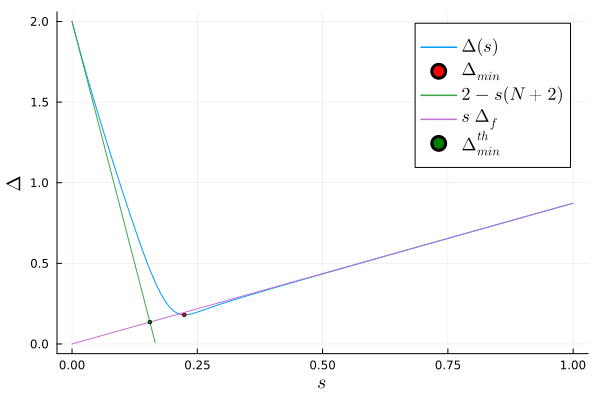

In [8]:
plot(S, [Delta],# overlap[:, 1] , overlap[:, 2]],
     label=[L"\Delta (s)" L"| \langle \psi_0 | \psi \rangle |^2" L"| \langle \psi_1 | \psi \rangle |^2"])

plot!([S[argmin(Delta)]], [Delta[argmin(Delta)]], seriestype=:scatter, label=L"\Delta_{min}", markersize=2, color=:red)

# plot!(S, E_eff[:, 2] .- E_eff[:, 1])

plot!(S[1:argmin(abs.(2 .- (N+2) * S))], 2 .- (N+2) * S[1:argmin(abs.(2 .- (N+2) * S))], label=L"2 - s (N+2)")
plot!(S, df*S, label=L"s\ \Delta_{f}")

sc_first = 2 / (2+N+df)
dmin_first = sc_first * df
plot!([sc_first], [dmin_first], seriestype=:scatter, label=L"\Delta_{min}^{th}", markersize=2, color=:green)
plot!(xlabel=L"s", ylabel=L"\Delta")
plot!(legendfontsize=12, labelfontsize=13)
# savefig("ex_delta.pdf")
# vline!([S[argmax(dH)]], label=L"arg\max_s <\frac{dH}{ds}>")

In [9]:
using LsqFit

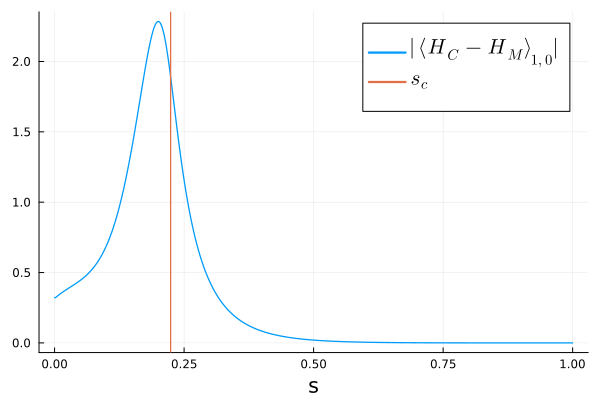

In [10]:
f_fit(s, p) = p[1] * (1 .- s).^p[2] ./ s.^p[2]

sc_ind = argmin(Delta)
sc = S[sc_ind]
p0 = [1e0, dh]
fit = curve_fit(f_fit, S[sc_ind:end], dH[sc_ind:end], p0)

plot(S, dH, label=L"| \langle H_C - H_M \rangle_{1,0} |", linewidth=1.3)
# plot!(S[sc_ind:end], f_fit(S[sc_ind:end], fit.param))
vline!([sc], xlabel="s", label=L"s_c", linewidth=1.3)
plot!(xlabel="s", legendfontsize=14, labelfontsize=14)
# savefig("analysis/plots/ex_dH.pdf")

In [11]:
fit.param, dh

([0.017982188618949853, 3.7741249468819613], 4)

In [12]:
using NumericalIntegration

In [13]:
M = 501
opt = zeros(M)
for i in 1:M
    opt[i] = integrate(S[1:i], Delta[1:i].^2 ./ dH[1:i])
end

In [14]:
dw = 1

T_opt = 1 / opt[end]

2.8597350012451825e-8

21.040966727894993
18.04270462633452


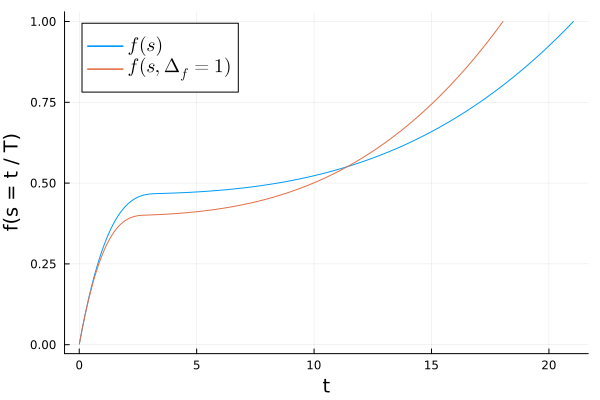

In [17]:
Sa_o = LinRange(0, 2/(2+N+df), 501)
fa_o = 1/3 .* Sa_o .* (12 .- 6*(2 + N).*Sa_o .+ (2 + N)^2 .*Sa_o.^2)

Sb_o = LinRange(2/(2+N+df), 1, 501)
fb_o = 1/3 .* (Sb_o.^3 .* df^2 .+ (8*(2 + N + 2*df))/(2 + N + df)^2)

S_o = [Sa_o; Sb_o][2:end]
f_o = [fa_o; fb_o][2:end]

T_o = 3*N / (df^2 .+ (8 * (2 + N + 2*df))/(2 + N + df)^2)
println(T_o)
plot(S_o*T_o, T_o/N*f_o, label=L"f(s)")

Sa_o = LinRange(0, 2/(2+N+dw), 501)
fa_o = 1/3 .* Sa_o .* (12 .- 6*(2 + N).*Sa_o .+ (2 + N)^2 .*Sa_o.^2)

Sb_o = LinRange(2/(2+N+dw), 1, 501)
fb_o = 1/3 .* (Sb_o.^3 .* dw^2 .+ (8*(2 + N + 2*dw))/(2 + N + dw)^2)

S_o1 = [Sa_o; Sb_o][2:end]
f_o1 = [fa_o; fb_o][2:end]

T_s1 = 3*N / (dw^2 .+ (8 * (2 + N + 2*dw))/(2 + N + dw)^2)
println(T_s1)
plot!(S_o1*T_s1, T_s1/N*f_o1, label=L"f(s, \Delta_f=1)")

# plot!(S[2:end]*T_opt, opt[2:end] / opt[end])
plot!(xlabel="t", ylabel="f(s = t / T)", legendfontsize=13, labelfontsize=13)
# hline!([S[argmin(Delta)], 2/(2+N+df), 2/(2+N+dw)])
# savefig("analysis/plots/f_ex.pdf")

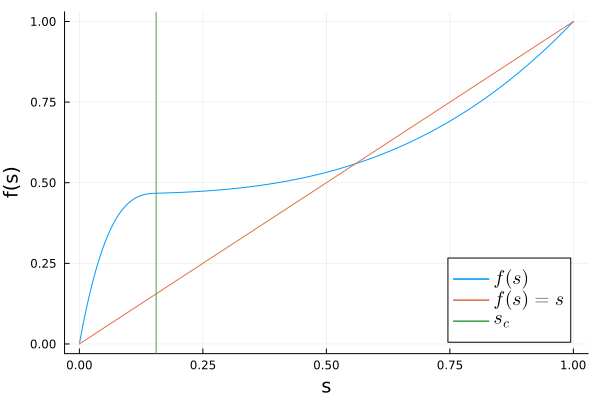

In [16]:
Sa_o = LinRange(0, 2/(2+N+df), 302)
fa_o = 1/3 .* Sa_o .* (12 .- 6*(2 + N).*Sa_o .+ (2 + N)^2 .*Sa_o.^2)

Sb_o = LinRange(2/(2+N+df), 1, 200)
fb_o = 1/3 .* (Sb_o.^3 .* df^2 .+ (8*(2 + N + 2*df))/(2 + N + df)^2)

S_o = [Sa_o; Sb_o][2:end]
f_o = [fa_o; fb_o][2:end]

T_o = 3*N / (df^2 .+ (8 * (2 + N + 2*df))/(2 + N + df)^2)

plot(S_o, T_o/N*f_o, label=L"f(s)")
plot!(S, S, label=L"f(s) = s")
vline!([2/(2+N+df)], label=L"s_c")
plot!(xlabel="s", ylabel="f(s)", labelfontsize=13, legendfontsize=13)
# savefig("analysis/plots/ex_fs.pdf")